In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=a861a367b56ccde8177bd3f57c3683a509b27f3245cec81cfb48336ff75938c3
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


# Step 1: Set Up the Environment
First, start by setting up a Spark session and loading the data.

In [17]:
# Import SparkSession
from pyspark.sql import SparkSession

# Import required functions and classes
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Machine Learning libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NFL Yardage EDA") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/kaggle/input/nfl-big-data-bowl-2020/train.csv", header=True, inferSchema=True)

# Show the schema to understand the structure of the data
df.printSchema()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/02 12:17:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- GameId: integer (nullable = true)
 |-- PlayId: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- S: double (nullable = true)
 |-- A: double (nullable = true)
 |-- Dis: double (nullable = true)
 |-- Orientation: double (nullable = true)
 |-- Dir: double (nullable = true)
 |-- NflId: integer (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- JerseyNumber: integer (nullable = true)
 |-- Season: integer (nullable = true)
 |-- YardLine: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- PossessionTeam: string (nullable = true)
 |-- Down: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- FieldPosition: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- NflIdRusher: integer (nullable = true)
 |-- OffenseFormation: string

# Step 2: EDA

In [4]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")


Number of rows: 682154
Number of columns: 49


In [5]:
df.show(5)


24/09/02 12:18:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------+----+-----+-----+----+----+----+-----------+------+-------+---------------+------------+------+--------+-------+-------------------+--------------+----+--------+-------------+-------------------+----------------------+-----------+----------------+----------------+-----------------+----------------+-------------+-------------------+-------------------+-----+------------+------------+---------------+-----------------+--------+------------+---------------+----+----------------+--------------+-----------+----------+--------------+-----------+--------+---------+-------------+
|    GameId|        PlayId|Team|    X|    Y|   S|   A| Dis|Orientation|   Dir|  NflId|    DisplayName|JerseyNumber|Season|YardLine|Quarter|          GameClock|PossessionTeam|Down|Distance|FieldPosition|HomeScoreBeforePlay|VisitorScoreBeforePlay|NflIdRusher|OffenseFormation|OffensePersonnel|DefendersInTheBox|DefensePersonnel|PlayDirection|        TimeHandoff|           TimeSnap|Yards|PlayerHei

In [6]:
df.describe().show()


+-------+--------------------+-------------------+------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-----------------+----------------+------------------+------------------+------------------+------------------+--------------+------------------+-----------------+-------------+-------------------+----------------------+------------------+----------------+--------------------+------------------+--------------------+-------------+-----------------+------------+------------------+---------------+-----------------+--------+------------+---------------+-----------------+---------------+-------------+-----------+-------------+------------------+------------------+-----------------+-----------------+-----------------+
|summary|              GameId|             PlayId|  Team|                X|                 Y|                 S|                 A|                Dis|      Orientation|               Dir|  

In [7]:
from pyspark.sql.functions import col, sum

# Count missing values in each column
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


+------+------+----+---+---+---+---+---+-----------+---+-----+-----------+------------+------+--------+-------+---------+--------------+----+--------+-------------+-------------------+----------------------+-----------+----------------+----------------+-----------------+----------------+-------------+-----------+--------+-----+------------+------------+---------------+-----------------+--------+------------+---------------+----+-------+--------+-----------+----+-----------+-----------+--------+---------+-------------+
|GameId|PlayId|Team|  X|  Y|  S|  A|Dis|Orientation|Dir|NflId|DisplayName|JerseyNumber|Season|YardLine|Quarter|GameClock|PossessionTeam|Down|Distance|FieldPosition|HomeScoreBeforePlay|VisitorScoreBeforePlay|NflIdRusher|OffenseFormation|OffensePersonnel|DefendersInTheBox|DefensePersonnel|PlayDirection|TimeHandoff|TimeSnap|Yards|PlayerHeight|PlayerWeight|PlayerBirthDate|PlayerCollegeName|Position|HomeTeamAbbr|VisitorTeamAbbr|Week|Stadium|Location|StadiumType|Turf|GameWeathe

In [8]:
df.select("Team").distinct().show()
df.select("OffenseFormation").distinct().show()


+----+
|Team|
+----+
|away|
|home|
+----+



+----------------+
|OffenseFormation|
+----------------+
|          PISTOL|
|           EMPTY|
|         WILDCAT|
|      SINGLEBACK|
|          I_FORM|
|           JUMBO|
|         SHOTGUN|
|             ACE|
|            NULL|
+----------------+



In [9]:
df.groupBy("Team").count().show()
df.groupBy("OffenseFormation").count().show()


+----+------+
|Team| count|
+----+------+
|away|341077|
|home|341077|
+----+------+



+----------------+------+
|OffenseFormation| count|
+----------------+------+
|          PISTOL| 21538|
|            NULL|    88|
|           EMPTY|   682|
|         WILDCAT|  1694|
|      SINGLEBACK|299728|
|          I_FORM|136950|
|           JUMBO| 14894|
|         SHOTGUN|206558|
|             ACE|    22|
+----------------+------+



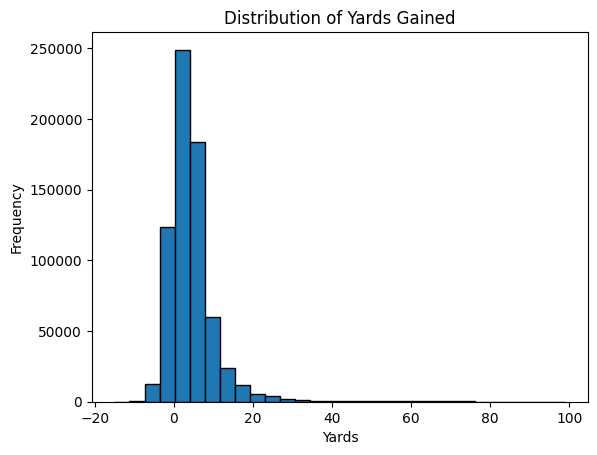

In [10]:
import matplotlib.pyplot as plt

# Collect the data for Yards column
yards_data = df.select("Yards").rdd.flatMap(lambda x: x).collect()

# Plot the distribution
plt.hist(yards_data, bins=30, edgecolor='black')
plt.title("Distribution of Yards Gained")
plt.xlabel("Yards")
plt.ylabel("Frequency")
plt.show()


In [11]:
from pyspark.sql.functions import corr

# Compute correlation between 'Yards' and other numerical features
corr_df = df.select(
    corr("Yards", "S").alias("Yards_vs_S"),
    corr("Yards", "A").alias("Yards_vs_A"),
    corr("Yards", "X").alias("Yards_vs_X"),
    corr("Yards", "Y").alias("Yards_vs_Y")
)

corr_df.show()


+--------------------+------------------+--------------------+--------------------+
|          Yards_vs_S|        Yards_vs_A|          Yards_vs_X|          Yards_vs_Y|
+--------------------+------------------+--------------------+--------------------+
|0.003393453794717...|0.0199700664506995|0.002226143526931104|-0.00187672549038...|
+--------------------+------------------+--------------------+--------------------+



In [12]:
from pyspark.sql.functions import corr

# Compute correlation between 'Yards' and other numerical features
corr_df = df.select(
    corr("Yards", "S").alias("Yards_vs_S"),
    corr("Yards", "A").alias("Yards_vs_A"),
    corr("Yards", "X").alias("Yards_vs_X"),
    corr("Yards", "Y").alias("Yards_vs_Y")
)

corr_df.show()


+--------------------+------------------+--------------------+--------------------+
|          Yards_vs_S|        Yards_vs_A|          Yards_vs_X|          Yards_vs_Y|
+--------------------+------------------+--------------------+--------------------+
|0.003393453794717...|0.0199700664506995|0.002226143526931104|-0.00187672549038...|
+--------------------+------------------+--------------------+--------------------+



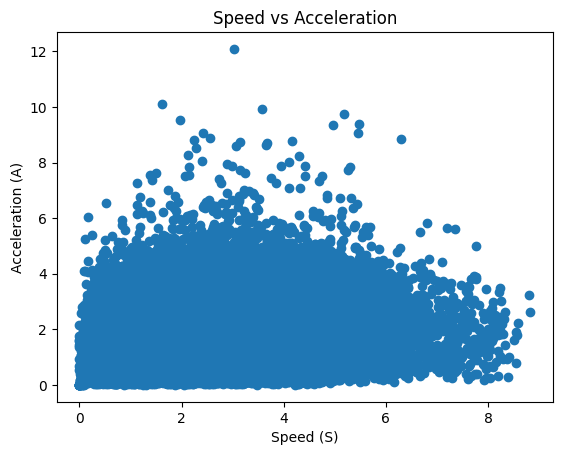

In [13]:
speed_acceleration = df.select("S", "A").sample(False, 0.1).toPandas()

plt.scatter(speed_acceleration["S"], speed_acceleration["A"])
plt.title("Speed vs Acceleration")
plt.xlabel("Speed (S)")
plt.ylabel("Acceleration (A)")
plt.show()


In [14]:
df.groupBy("OffenseFormation").pivot("Down").avg("Yards").show()


+----------------+------------------+------------------+------------------+------------------+
|OffenseFormation|                 1|                 2|                 3|                 4|
+----------------+------------------+------------------+------------------+------------------+
|          PISTOL|  4.92991452991453|4.2727272727272725|3.8732394366197185|               1.5|
|            NULL|               3.0|              NULL|              NULL|              NULL|
|           EMPTY| 4.411764705882353|             5.625|               4.4|              -5.0|
|         WILDCAT| 4.794117647058823|3.6538461538461537|             6.125|               4.0|
|      SINGLEBACK| 4.306682577565632| 4.200902934537246|3.5497896213183733|1.6732673267326732|
|          I_FORM| 4.309418210279155|  3.87772461456672|  3.30184331797235|2.8051948051948052|
|           JUMBO|1.9142857142857144| 1.413265306122449|2.5419847328244276|               0.4|
|         SHOTGUN| 4.388269918015556| 4.5234994337

In [15]:
df.groupBy("GameWeather").avg("Yards").orderBy("avg(Yards)", ascending=False).show()


+--------------------+------------------+
|         GameWeather|        avg(Yards)|
+--------------------+------------------+
|         Sunny Skies| 6.086956521739131|
|Sunny, highs to u...|              5.56|
|      Clear and warm|5.5576923076923075|
|      Clear and cold|5.4655172413793105|
|  30% Chance of Rain|5.4423076923076925|
|Cloudy with showe...|5.2444444444444445|
|     Clear and Sunny| 5.111111111111111|
|      Clear and Cool| 4.957446808510638|
|Cloudy, chance of...| 4.853658536585366|
|       Mostly cloudy| 4.823717948717949|
|Cloudy, fog start...|               4.8|
|      Partly Clouidy|               4.8|
|               sUNNY| 4.695652173913044|
|        Cloudy, Rain|              4.64|
|Cloudy, 50% chang...| 4.638297872340425|
|        Party Cloudy| 4.594594594594595|
|     Clear and sunny| 4.591836734693878|
|      Sunny and cold| 4.488888888888889|
|        Mostly Sunny| 4.487704918032787|
|        Sunny, Windy| 4.472222222222222|
+--------------------+------------

In [16]:
df.groupBy("Turf").avg("Yards").orderBy("avg(Yards)", ascending=False).show()


+--------------------+------------------+
|                Turf|        avg(Yards)|
+--------------------+------------------+
|UBU-Speed Series-...| 7.368421052631579|
|Twenty-Four/Seven...| 4.808219178082192|
|            SISGrass| 4.734299516908212|
|Twenty Four/Seven...| 4.439688715953308|
|UBU Speed Series-...| 4.392838609237156|
|       FieldTurf 360| 4.334384858044164|
|       Natural Grass| 4.328703703703703|
|             Natural| 4.324324324324325|
|        A-Turf Titan|4.2502369668246445|
|UBU Sports Speed ...| 4.233933161953727|
|        FieldTurf360| 4.204787234042553|
|          Field Turf| 4.175162504276428|
|               Grass| 4.175032302951993|
|          Artificial| 4.152322924600153|
|       Natural grass|4.1258907363420425|
|           FieldTurf|   4.1012599160056|
|      DD GrassMaster| 3.893732970027248|
|           Artifical| 3.699059561128527|
|       natural grass|3.3783783783783785|
|      Naturall Grass| 3.358974358974359|
+--------------------+------------

# Step 3: Data Preparation
    1. Handling Missing Values
    Start by handling missing values in both numerical and categorical columns.

In [20]:
from pyspark.sql.functions import col, sum

# Count missing values in each column
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()


+------+------+----+---+---+---+---+---+-----------+---+-----+-----------+------------+------+--------+-------+---------+--------------+----+--------+-------------+-------------------+----------------------+-----------+----------------+----------------+-----------------+----------------+-------------+-----------+--------+-----+------------+------------+---------------+-----------------+--------+------------+---------------+----+-------+--------+-----------+----+-----------+-----------+--------+---------+-------------+
|GameId|PlayId|Team|  X|  Y|  S|  A|Dis|Orientation|Dir|NflId|DisplayName|JerseyNumber|Season|YardLine|Quarter|GameClock|PossessionTeam|Down|Distance|FieldPosition|HomeScoreBeforePlay|VisitorScoreBeforePlay|NflIdRusher|OffenseFormation|OffensePersonnel|DefendersInTheBox|DefensePersonnel|PlayDirection|TimeHandoff|TimeSnap|Yards|PlayerHeight|PlayerWeight|PlayerBirthDate|PlayerCollegeName|Position|HomeTeamAbbr|VisitorTeamAbbr|Week|Stadium|Location|StadiumType|Turf|GameWeathe

In [23]:
# Display columns with missing values
missing_values.show()
# Fill missing numerical values with median
from pyspark.sql.functions import expr
from pyspark.sql.functions import col

# Convert WindSpeed (and other similar columns) from StringType to FloatType
df = df.withColumn("WindSpeed", col("WindSpeed").cast("float"))

# Now, proceed with calculating the median
numerical_cols = ['DefendersInTheBox', 'Temperature', 'Humidity', 'WindSpeed']

for col_name in numerical_cols:
    median_val = df.approxQuantile(col_name, [0.5], 0.25)[0]
    df = df.na.fill({col_name: median_val})


# Fill missing categorical values with 'Unknown'
categorical_cols = ['OffenseFormation', 'StadiumType', 'Turf', 'GameWeather']
df = df.na.fill('Unknown', subset=categorical_cols)



+------+------+----+---+---+---+---+---+-----------+---+-----+-----------+------------+------+--------+-------+---------+--------------+----+--------+-------------+-------------------+----------------------+-----------+----------------+----------------+-----------------+----------------+-------------+-----------+--------+-----+------------+------------+---------------+-----------------+--------+------------+---------------+----+-------+--------+-----------+----+-----------+-----------+--------+---------+-------------+
|GameId|PlayId|Team|  X|  Y|  S|  A|Dis|Orientation|Dir|NflId|DisplayName|JerseyNumber|Season|YardLine|Quarter|GameClock|PossessionTeam|Down|Distance|FieldPosition|HomeScoreBeforePlay|VisitorScoreBeforePlay|NflIdRusher|OffenseFormation|OffensePersonnel|DefendersInTheBox|DefensePersonnel|PlayDirection|TimeHandoff|TimeSnap|Yards|PlayerHeight|PlayerWeight|PlayerBirthDate|PlayerCollegeName|Position|HomeTeamAbbr|VisitorTeamAbbr|Week|Stadium|Location|StadiumType|Turf|GameWeathe

    2. Feature Engineering
    Convert categorical features into numerical ones and assemble the features into a vector.

In [24]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Index categorical features
indexers = [
    StringIndexer(inputCol="Team", outputCol="TeamIndexed"),
    StringIndexer(inputCol="OffenseFormation", outputCol="OffenseFormationIndexed"),
    StringIndexer(inputCol="PlayDirection", outputCol="PlayDirectionIndexed"),
    StringIndexer(inputCol="StadiumType", outputCol="StadiumTypeIndexed"),
    StringIndexer(inputCol="GameWeather", outputCol="GameWeatherIndexed")
]

# Assemble the feature columns into a single vector
assembler = VectorAssembler(
    inputCols=["S", "A", "DefendersInTheBox", "Temperature", "Humidity", 
               "WindSpeed", "TeamIndexed", "OffenseFormationIndexed", 
               "PlayDirectionIndexed", "StadiumTypeIndexed", "GameWeatherIndexed"],
    outputCol="features"
)

# Optional: Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Create a pipeline for data preparation
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + [assembler, scaler])
model_pipeline = pipeline.fit(df)
df_transformed = model_pipeline.transform(df)

# Show transformed data
df_transformed.select("scaledFeatures", "Yards").show(5)


+--------------------+-----+
|      scaledFeatures|Yards|
+--------------------+-----+
|[1.20304150726440...|    8|
|[0.29898072961600...|    8|
|[0.86846783364649...|    8|
|[0.29898072961600...|    8|
|[1.29558316166936...|    8|
+--------------------+-----+
only showing top 5 rows



# Step 3: Train-Test Split
Split the dataset into training and testing sets.

In [25]:
train, test = df_transformed.randomSplit([0.8, 0.2], seed=42)


# Step 4: Model Training

1. Linear Regression

In [26]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Yards")

# Train the model on the training data
lr_model = lr.fit(train)

# Make predictions on the test data
lr_predictions = lr_model.transform(test)

# Show some predictions
lr_predictions.select("Yards", "prediction").show(5)


24/09/02 12:32:52 WARN Instrumentation: [b5c3e2e2] regParam is zero, which might cause numerical instability and overfitting.
24/09/02 12:33:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/02 12:33:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+-----+-----------------+
|Yards|       prediction|
+-----+-----------------+
|    8|4.619808175722514|
|    8|4.622063139723074|
|    8|4.633699878885147|
|    8|4.700910508014448|
|    8|4.638144862484098|
+-----+-----------------+
only showing top 5 rows



2. Random Forest Regressor

In [27]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize the Random Forest model
rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="Yards")

# Train the model
rf_model = rf.fit(train)

# Make predictions
rf_predictions = rf_model.transform(test)

# Show some predictions
rf_predictions.select("Yards", "prediction").show(5)


+-----+----------------+
|Yards|      prediction|
+-----+----------------+
|    8|4.47684741789744|
|    8|4.47684741789744|
|    8|4.47684741789744|
|    8|4.47684741789744|
|    8|4.47684741789744|
+-----+----------------+
only showing top 5 rows



3. Gradient-Boosted Trees Regressor

In [28]:
from pyspark.ml.regression import GBTRegressor

# Initialize the Gradient-Boosted Trees model
gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="Yards", maxIter=10)

# Train the model
gbt_model = gbt.fit(train)

# Make predictions
gbt_predictions = gbt_model.transform(test)

# Show some predictions
gbt_predictions.select("Yards", "prediction").show(5)


+-----+-----------------+
|Yards|       prediction|
+-----+-----------------+
|    8|4.997109344708163|
|    8|4.997109344708163|
|    8|4.997109344708163|
|    8|4.997109344708163|
|    8|5.029150798482295|
+-----+-----------------+
only showing top 5 rows



# Step 5: Model Evaluation
Evaluate the models using RMSE (Root Mean Squared Error) and R².

1. Linear Regression Evaluation

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the Linear Regression model
evaluator = RegressionEvaluator(labelCol="Yards", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)
lr_r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R²: {lr_r2}")


Linear Regression RMSE: 6.400048265599296
Linear Regression R²: 0.011785112978940693


2. Random Forest Evaluation


In [32]:
# Evaluate the Random Forest model
rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R²: {rf_r2}")


Random Forest RMSE: 6.386083504364005
Random Forest R²: 0.016092933335254522


3. Gradient-Boosted Trees Evaluation


In [30]:
# Evaluate the GBT model
gbt_rmse = evaluator.evaluate(gbt_predictions)
gbt_r2 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "r2"})

print(f"Gradient-Boosted Trees RMSE: {gbt_rmse}")
print(f"Gradient-Boosted Trees R²: {gbt_r2}")


Gradient-Boosted Trees RMSE: 6.360382818598798
Gradient-Boosted Trees R²: 0.023996432435513193


# Step 6: Hyperparameter Tuning 

In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define a parameter grid for Random Forest
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Initialize CrossValidator
crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross-validation
cv_model = crossval.fit(train)

# Evaluate the best model
cv_predictions = cv_model.transform(test)
cv_rmse = evaluator.evaluate(cv_predictions)
cv_r2 = evaluator.evaluate(cv_predictions, {evaluator.metricName: "r2"})

print(f"Cross-Validated Random Forest RMSE: {cv_rmse}")
print(f"Cross-Validated Random Forest R²: {cv_r2}")


24/09/02 12:35:53 WARN MemoryStore: Not enough space to cache rdd_601_1 in memory! (computed 39.9 MiB so far)
24/09/02 12:35:53 WARN BlockManager: Persisting block rdd_601_1 to disk instead.
24/09/02 12:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1406.1 KiB
24/09/02 12:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1533.2 KiB
24/09/02 12:36:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/09/02 12:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1416.7 KiB
24/09/02 12:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1521.3 KiB
24/09/02 12:37:44 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/09/02 12:38:05 WARN MemoryStore: Not enough space to cache rdd_1017_1 in memory! (computed 39.9 MiB so far)
24/09/02 12:38:05 WARN BlockManager: Persisting block rdd_1017_1 to disk instead.
24/09/02 12:38:31 WARN DAGScheduler: Broadcasting large task binary with size 1422.5 KiB

Cross-Validated Random Forest RMSE: 6.202718264662276
Cross-Validated Random Forest R²: 0.07178409784064521


# Step 7: Save The Model

In [33]:
# Define the path where you want to save the model
model_path = "best_model/cross_validated_random_forest"

# Save the model
cv_model.bestModel.write().overwrite().save(model_path)


# Step 8: Load Model

In [34]:
from pyspark.ml.regression import RandomForestRegressionModel

# Load the saved model
loaded_model = RandomForestRegressionModel.load(model_path)

# Use the loaded model to make predictions on new data
predictions = loaded_model.transform(test)
predictions.select("Yards", "prediction").show(5)


+-----+-----------------+
|Yards|       prediction|
+-----+-----------------+
|    8|4.644957755627412|
|    8|4.644957755627412|
|    8|4.644957755627412|
|    8|4.644957755627412|
|    8|4.642116856085264|
+-----+-----------------+
only showing top 5 rows

